# 2kr Assumptions Tests (Rectangular Scenario)

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

## Config

In [2]:
inputFile = 'data.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = ['T', 'D', 'R', 'm']

# Fitting
distsFit = ['norm'] # Distributions to fit
distsParams = [()] # Distributions params
outlierStddevDistance = 3 # Outliers identification

# Plots
histBinNum = 30 # Histograms
histCenter = True # Center distribution
plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
scatterShowLines = False
# Save
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum', 'Floorplan.collisions:sum', 'Floorplan.msgsPerSlot:sum']
# Filter vectors
vectorsFilter = ['Floorplan.coveredUsers:vector']
# Percentiles
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

# Residuals to compute
residualNames = [
    ('coveredUsersPercent', 'percentage of covered users (residuals)'),
    ('collisions', 'total number of collisions (residuals)'),
    ('msgsPerSlot', 'total number of messages sent (residuals)'),
]

# Transformations
transformations = [
]

intPercentiles = [int(i*100) for i in percentiles]
vecPerfIndexes = []
for intPercentile in intPercentiles:
    vecPerfIndexes.append(('broadcastTime' + str(intPercentile), 'Broadcast time needed to reach the ' + str(intPercentile) + 'th percentile of the coverage'))
for i, d in vecPerfIndexes:
    residualNames.append((i, d + ' (residuals)'))
    transformations.append((i, lambda x: math.log(x)))

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

# Computed
factorsCount = len(factors)
configsCount = 2**factorsCount
totalSims = configsCount*repetitionsCount

# Scatter plot whitelists
configsShown = range(0, configsCount)
repetitionsShown = range(0, repetitionsCount)


display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 10


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
for index, row in scalars[scalars.type == 'itervar'].iterrows():
    val = scalars.loc[index, 'attrvalue']
    if isinstance(val, str)  and not all(c.isdigit() for c in val):
        scalars.loc[index, 'attrvalue'] = eval(val)
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)

## Load vectors

In [6]:
vectors = df[df.type == 'vector']
vectors = vectors.assign(qname = vectors.module + '.' + vectors.name)
for index in scalars_wide.index:
    r = index
    cfg = scalars_wide.loc[index, 'config']
    rep = scalars_wide.loc[index, 'repetition']
    vectors.loc[vectors.run == r, 'config'] = cfg
    vectors.loc[vectors.run == r, 'repetition'] = rep
vectors = vectors[vectors.qname.isin(vectorsFilter)]
vectors.sort_values(['config', 'repetition', 'qname'], inplace=True)
vectors = vectors[['config', 'repetition', 'qname', 'vectime', 'vecvalue']]

## Compute scalars from vectors

In [7]:
def get_percentile(percentile, vectime, vecvalue, totalvalue):
    tofind = percentile * totalvalue
    idx = 0
    csum = vecvalue.cumsum()
    for value in csum:
        if value >= tofind:
            return vectime[idx]
        idx += 1
    return math.inf

for index, row in vectors.iterrows():
    for vecPerf, percentile in zip(vecPerfIndexes, percentiles):
        vecPerfIndex = vecPerf[0]
        cfg = row['config']
        rep = row['repetition']
        if vecPerfIndex.startswith('broadcastTime'):
            total = scalars_wide[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep)]['Floorplan.userCount'].values[0] - 1
        else:
            raise Exception('Need to specify total for ' + vecPerfIndex + '. (coding required)')
        value = get_percentile(percentile, row['vectime'], row['vecvalue'], total)
        scalars_wide.loc[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep), vecPerfIndex] = value

## Apply transformations

In [8]:
for col, transform in transformations:
    scalars_wide[col] = scalars_wide[col].map(transform, 'ignore')

## Compute residuals

In [9]:
# coverage
scalars_wide['coveredUsersPercentMean'] = scalars_wide.groupby(factors)['coveredUsersPercent'].transform('mean')
scalars_wide['coveredUsersPercentResidual'] = scalars_wide['coveredUsersPercent'] - scalars_wide['coveredUsersPercentMean']

# collisions
scalars_wide['collisionsMean'] = scalars_wide.groupby(factors)['Floorplan.collisions:sum'].transform('mean')
scalars_wide['collisionsResidual'] = scalars_wide['Floorplan.collisions:sum'] - scalars_wide['collisionsMean']

# msgsPerSlot
scalars_wide['msgsPerSlotMean'] = scalars_wide.groupby(factors)['Floorplan.msgsPerSlot:sum'].transform('mean')
scalars_wide['msgsPerSlotResidual'] = scalars_wide['Floorplan.msgsPerSlot:sum'] - scalars_wide['msgsPerSlotMean']

# vectors
skipped = []
for vecPerfIndex, _ in vecPerfIndexes:
    mean = scalars_wide.groupby(factors)[vecPerfIndex].transform('mean')
    nextVect = False
    for value in mean.values:
        if math.isinf(value):
            skipped.append(vecPerfIndex)
            nextVect = True
            continue
    if nextVect:
        continue
    scalars_wide[vecPerfIndex + 'Mean'] = mean
    scalars_wide[vecPerfIndex + 'Residual'] = scalars_wide[vecPerfIndex] - scalars_wide[vecPerfIndex + 'Mean']
for i, d in vecPerfIndexes:
    if i not in skipped:
        continue
    print(i + ' skipped due to infinite values in observations')
    residualNames.remove((i, d + ' (residuals)'))

## Residual distributions (histograms)

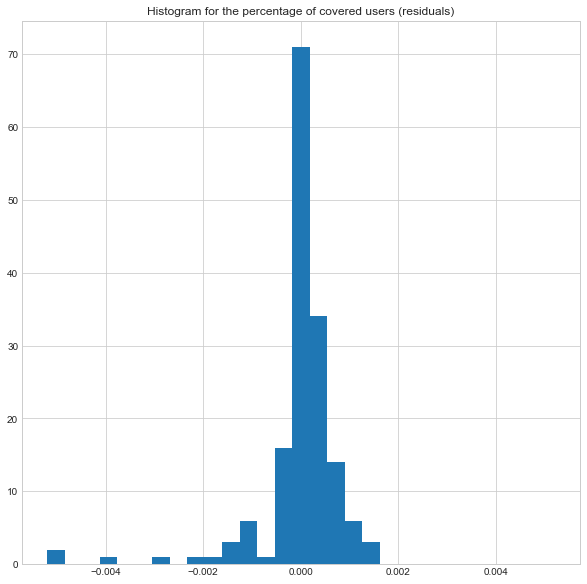

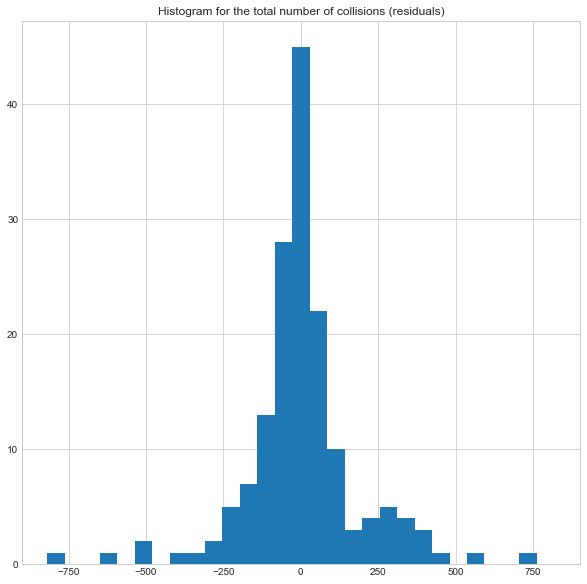

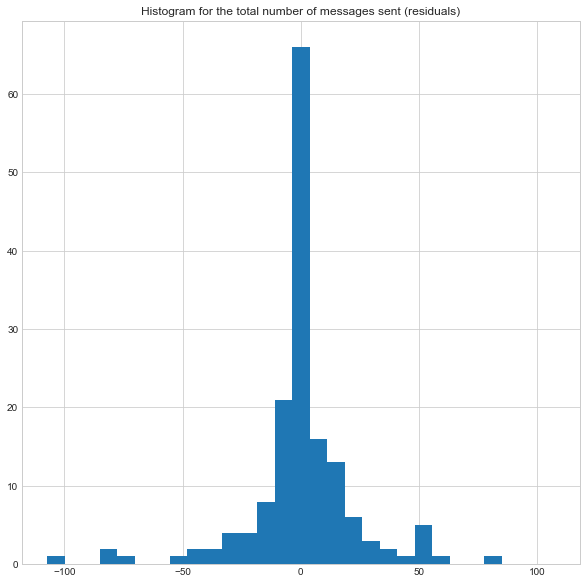

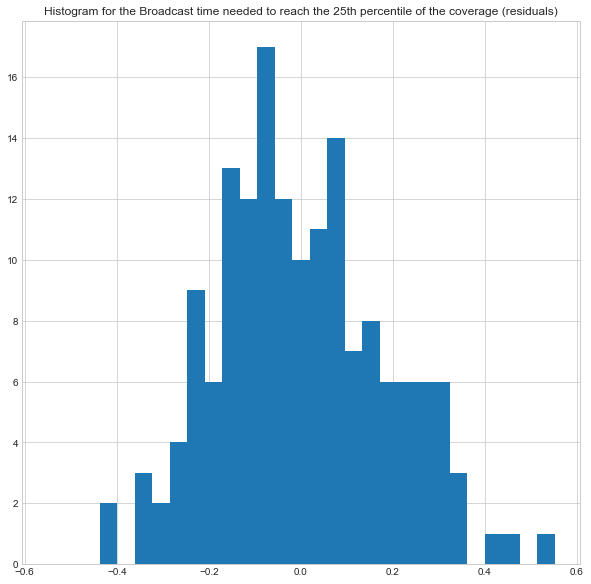

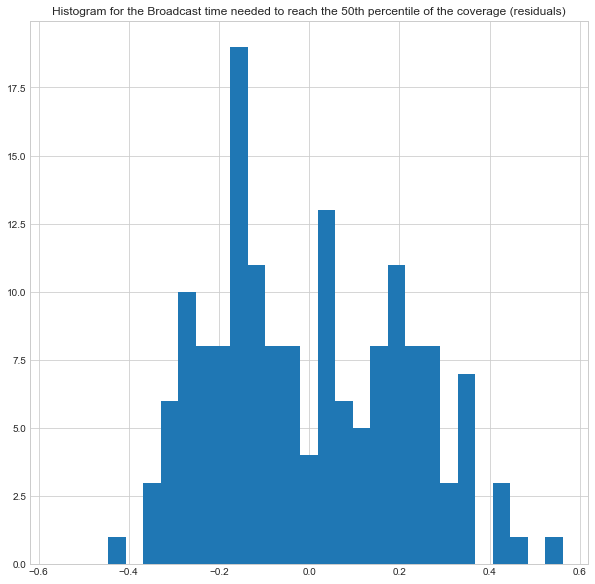

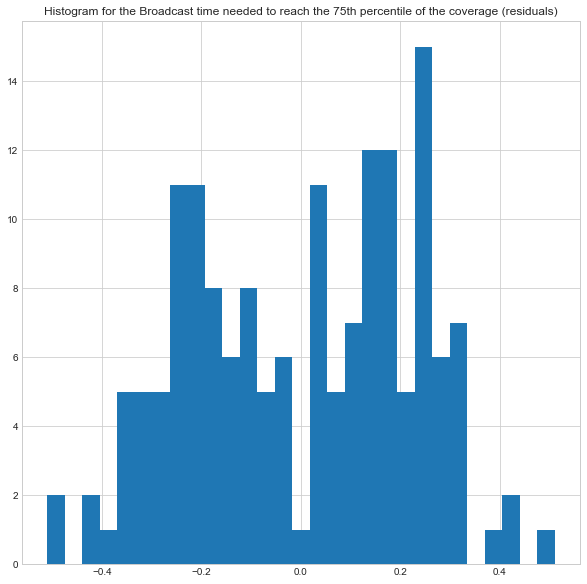

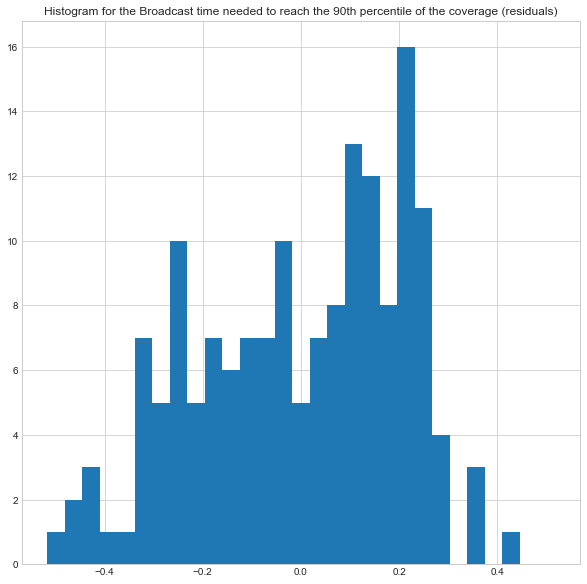

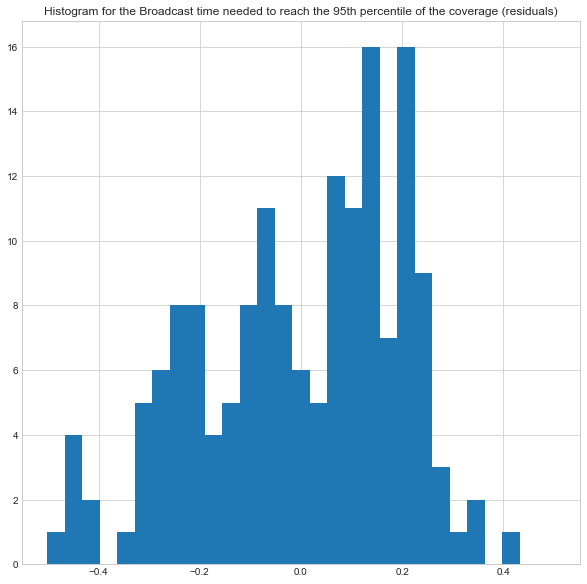

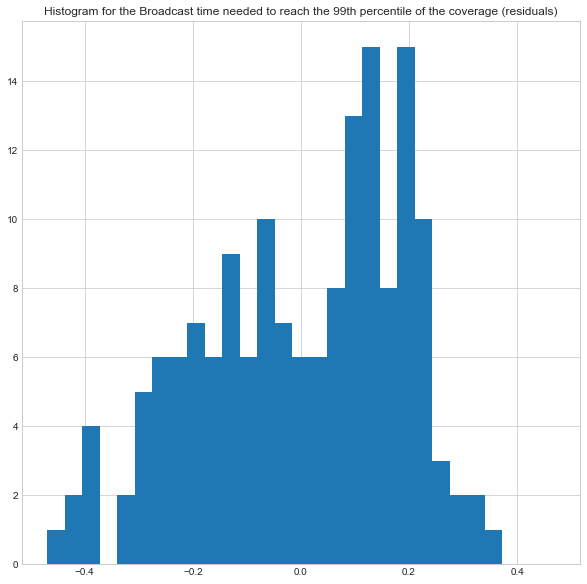

In [10]:
for varname, vardesc in residualNames:
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    minval = scalars_wide[varname + 'Residual'].min()
    maxval = scalars_wide[varname + 'Residual'].max()
    if histCenter:
        limit = max(abs(minval), abs(maxval))
        minval = -limit
        maxval = limit
    plt.hist(scalars_wide[varname + 'Residual'].values.tolist(), bins=np.linspace(minval, maxval, histBinNum))
    plt.title('Histogram for the ' + vardesc)
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + get_file_name(varname) + '-hist.png')
    plt.show()

### Notes on distributions

We can see from histograms that, for all indexes except the percentage of covered users, the distribution of the residuals seems normal. The percentage of covered user has a tail on the left.

## Distribution fitting

Trying to fit to a norm distribution:


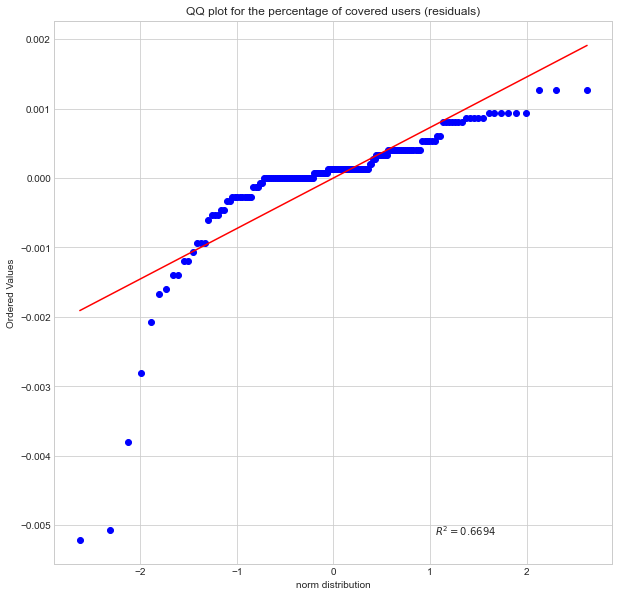

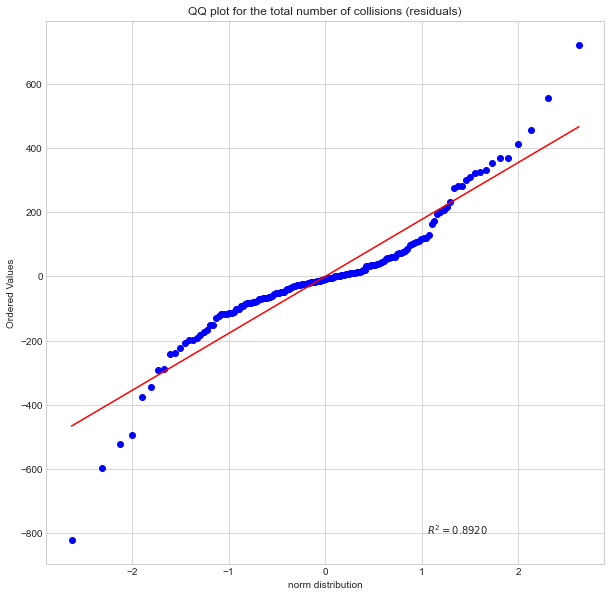

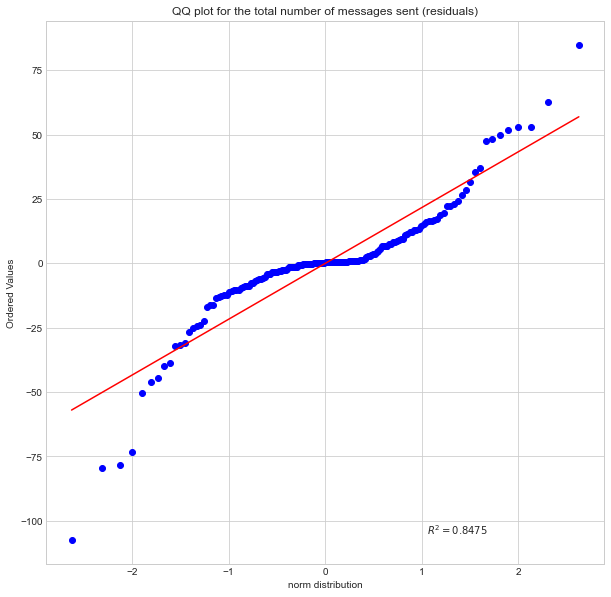

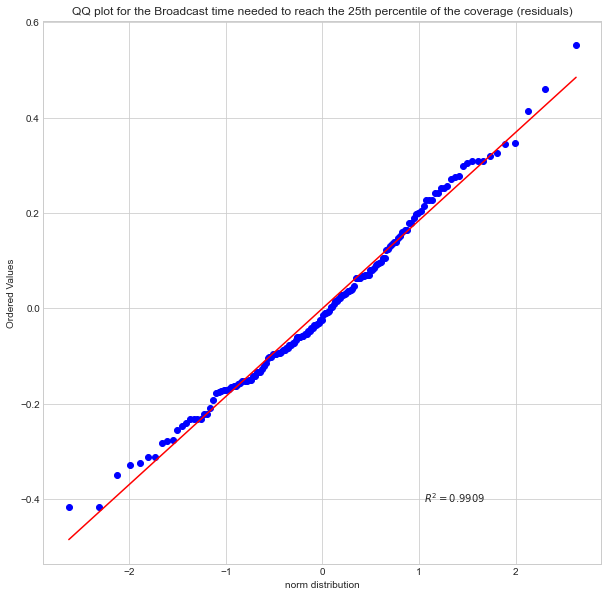

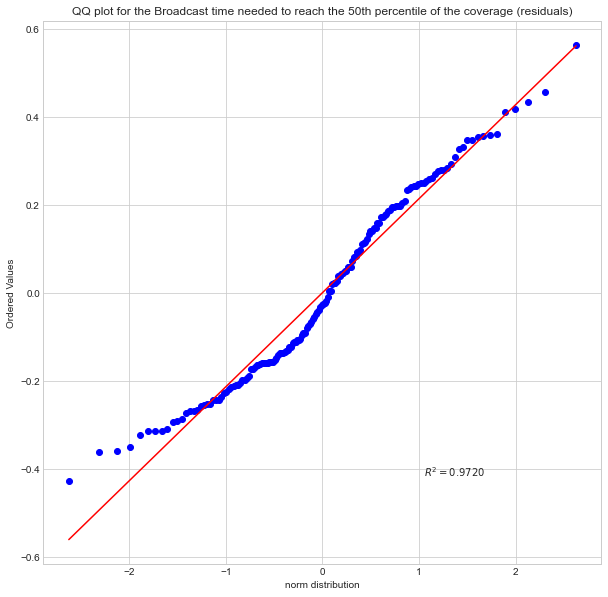

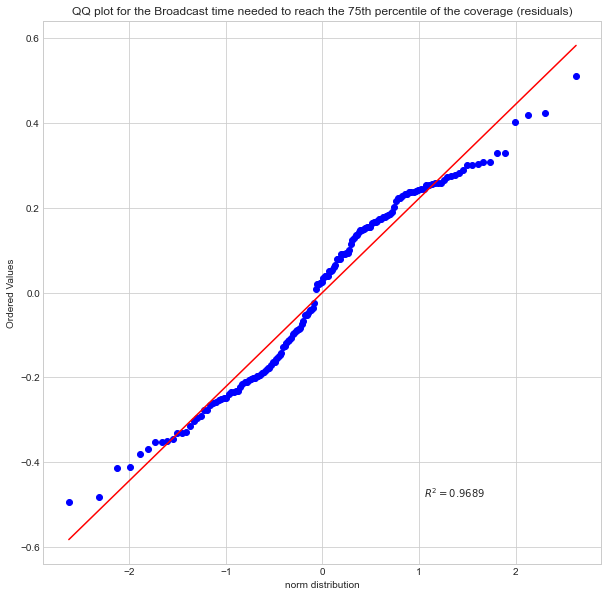

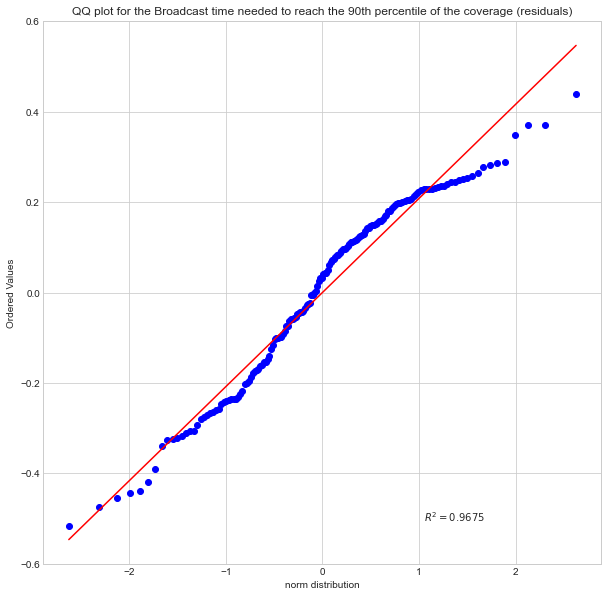

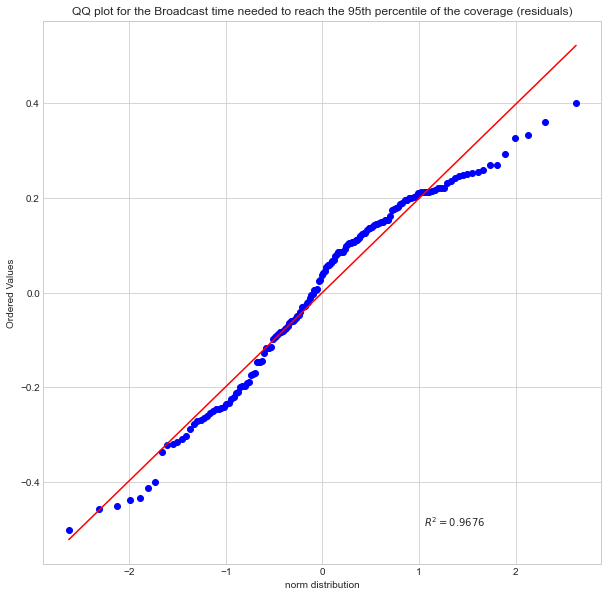

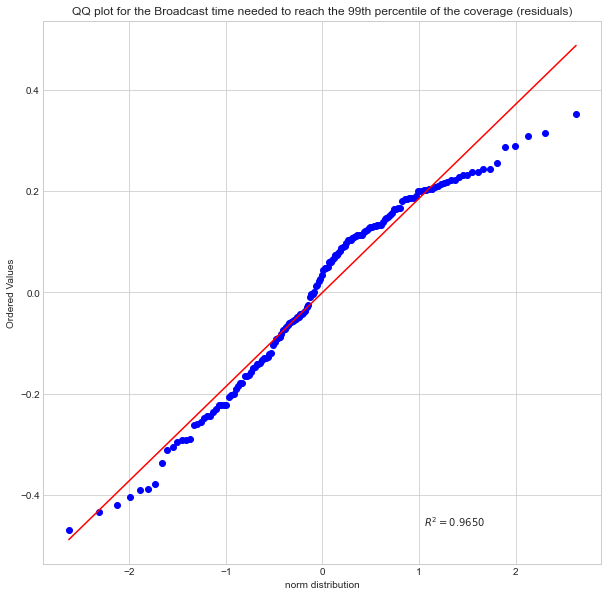

In [11]:
for distribution, params in zip(distsFit, distsParams):
    print('Trying to fit to a', distribution + ('({})'.format(', '.join(map(str, params))) if len(params) > 0 else ''), 'distribution:')
    for varname, vardesc in residualNames:
        plt.figure(figsize=plotSize)
        plt.style.use(plotStyle)
        residuals = scalars_wide[varname + 'Residual'].values.tolist()
        result, line = stats.probplot(residuals, dist=distribution, sparams=params, plot=plt, rvalue=True)
        #osm, _ = result
        #slope, intercept, _ = line
        plt.title("QQ plot for the " + vardesc)
        plt.xlabel(distribution + " distribution")
        if saveFigures:
            fig = plt.gcf()
            fig.savefig('figures/' + get_file_name(varname) + '-' + distribution + '-fit.png')
        plt.show()

### Notes on QQ plots

For all the indexes, except the percentage of covered users, we get "good" QQ-plots that signal a normal distribution of the residuals. The lowest R^2 index is given by the residuals of the total number of messages sent (R^2 = 0.8475).
We can see a slightly S-shape both in the collisions and in the messages. This is mainly due to the floorplan shape, which is rectangular and not square. This imply that users are distributed flat in the plan and we have a very marked distinction on the behaviour on the center and on the floor sides, which leads to some outliers, depending mainly on the random position of the starting node. 

As in the other scenarios the percentage of covered users will not be studied in the continue of this experiments, because it is still perfect in all the cases. There will be a new different study for this index

### Outliers

In [12]:
for varname, vardesc in residualNames:
    print('Outliers for the ' + vardesc)
    stddev = scalars_wide[varname + 'Residual'].std()
    limit = outlierStddevDistance*stddev
    print('total mean:', scalars_wide[varname + 'Mean'].mean())
    print('stddev:', stddev)
    print(str(outlierStddevDistance) + '*stddev:', limit)
    outliers = scalars_wide[np.abs(scalars_wide[varname + 'Residual']) > limit]
    display(outliers[['config', 'repetition', *factors, varname + 'Residual', varname + 'Mean']])

Outliers for the percentage of covered users (residuals)
total mean: 0.9995997331554369
stddev: 0.000878930116938135
3*stddev: 0.0026367903508144053


qname,config,repetition,T,D,R,m,coveredUsersPercentResidual,coveredUsersPercentMean
run,,,,,,,,
Rectangular2kr-37-20210607-09:28:53-26045,3.0,7.0,5.0,5.0,20.0,6.0,-0.002802,0.999466
Rectangular2kr-82-20210607-09:31:51-26555,8.0,2.0,10.0,5.0,10.0,2.0,-0.005070,0.999066
Rectangular2kr-99-20210607-09:32:17-26585,10.0,9.0,10.0,5.0,20.0,2.0,-0.005203,0.999199
Rectangular2kr-123-20210607-09:34:15-26912,12.0,3.0,10.0,10.0,10.0,2.0,-0.003803,0.999133


Outliers for the total number of collisions (residuals)
total mean: 2620.4625
stddev: 185.96365371530175
3*stddev: 557.8909611459053


qname,config,repetition,T,D,R,m,collisionsResidual,collisionsMean
run,,,,,,,,
Rectangular2kr-13-20210607-09:28:45-26040,2.0,3.0,5.0,5.0,20.0,2.0,-819.6,3774.6
Rectangular2kr-14-20210607-09:29:03-26040,2.0,4.0,5.0,5.0,20.0,2.0,719.4,3774.6
Rectangular2kr-96-20210607-09:31:37-26585,10.0,6.0,10.0,5.0,20.0,2.0,-596.3,3006.3


Outliers for the total number of messages sent (residuals)
total mean: 1163.59375
stddev: 23.323767131566616
3*stddev: 69.97130139469985


qname,config,repetition,T,D,R,m,msgsPerSlotResidual,msgsPerSlotMean
run,,,,,,,,
Rectangular2kr-11-20210607-09:28:07-26040,2.0,1.0,5.0,5.0,20.0,2.0,84.7,844.3
Rectangular2kr-13-20210607-09:28:45-26040,2.0,3.0,5.0,5.0,20.0,2.0,-107.3,844.3
Rectangular2kr-19-20210607-09:29:06-26041,2.0,9.0,5.0,5.0,20.0,2.0,-73.3,844.3
Rectangular2kr-96-20210607-09:31:37-26585,10.0,6.0,10.0,5.0,20.0,2.0,-78.3,638.3
Rectangular2kr-139-20210607-09:34:10-26929,14.0,9.0,10.0,10.0,20.0,2.0,-79.5,513.5


Outliers for the Broadcast time needed to reach the 25th percentile of the coverage (residuals)
total mean: 3.8369690155765945
stddev: 0.18338647866103142
3*stddev: 0.5501594359830942


qname,config,repetition,T,D,R,m,broadcastTime25Residual,broadcastTime25Mean
run,,,,,,,,
Rectangular2kr-96-20210607-09:31:37-26585,10.0,6.0,10.0,5.0,20.0,2.0,0.551164,3.607719


Outliers for the Broadcast time needed to reach the 50th percentile of the coverage (residuals)
total mean: 4.419216406591768
stddev: 0.2145752197482326
3*stddev: 0.6437256592446978


qname,config,repetition,T,D,R,m,broadcastTime50Residual,broadcastTime50Mean
run,,,,,,,,


Outliers for the Broadcast time needed to reach the 75th percentile of the coverage (residuals)
total mean: 4.8652387919936
stddev: 0.22305069278198297
3*stddev: 0.6691520783459489


qname,config,repetition,T,D,R,m,broadcastTime75Residual,broadcastTime75Mean
run,,,,,,,,


Outliers for the Broadcast time needed to reach the 90th percentile of the coverage (residuals)
total mean: 5.0961881177323
stddev: 0.20946385380485416
3*stddev: 0.6283915614145625


qname,config,repetition,T,D,R,m,broadcastTime90Residual,broadcastTime90Mean
run,,,,,,,,


Outliers for the Broadcast time needed to reach the 95th percentile of the coverage (residuals)
total mean: 5.165690697273185
stddev: 0.19955701138215048
3*stddev: 0.5986710341464514


qname,config,repetition,T,D,R,m,broadcastTime95Residual,broadcastTime95Mean
run,,,,,,,,


Outliers for the Broadcast time needed to reach the 99th percentile of the coverage (residuals)
total mean: 5.237180140237423
stddev: 0.18699024048958274
3*stddev: 0.5609707214687483


qname,config,repetition,T,D,R,m,broadcastTime99Residual,broadcastTime99Mean
run,,,,,,,,


## Independency test

qname,config,T,D,R,m
run,,,,,
Rectangular2kr-0-20210607-09:27:50-26038,0.0,5.0,5.0,10.0,2.0
Rectangular2kr-20-20210607-09:27:50-26042,1.0,5.0,5.0,10.0,6.0
Rectangular2kr-10-20210607-09:27:50-26040,2.0,5.0,5.0,20.0,2.0
Rectangular2kr-30-20210607-09:27:50-26044,3.0,5.0,5.0,20.0,6.0
Rectangular2kr-40-20210607-09:29:23-26307,4.0,5.0,10.0,10.0,2.0
Rectangular2kr-60-20210607-09:30:30-26462,5.0,5.0,10.0,10.0,6.0
Rectangular2kr-50-20210607-09:29:41-26347,6.0,5.0,10.0,20.0,2.0
Rectangular2kr-70-20210607-09:30:34-26472,7.0,5.0,10.0,20.0,6.0
Rectangular2kr-80-20210607-09:31:09-26555,8.0,10.0,5.0,10.0,2.0


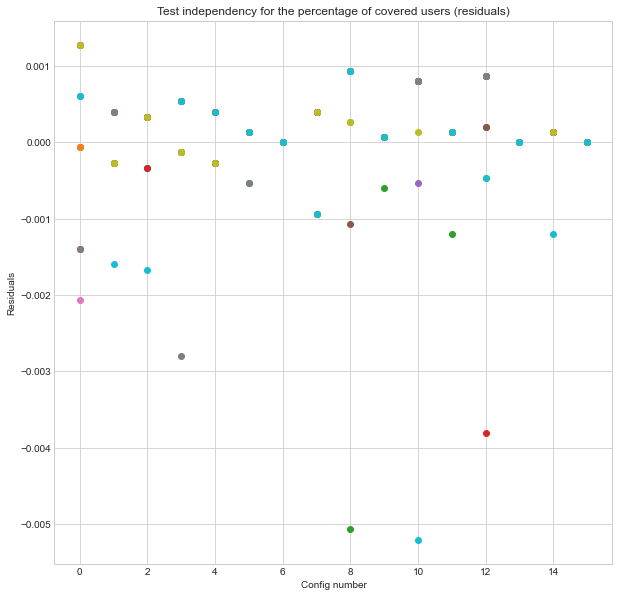

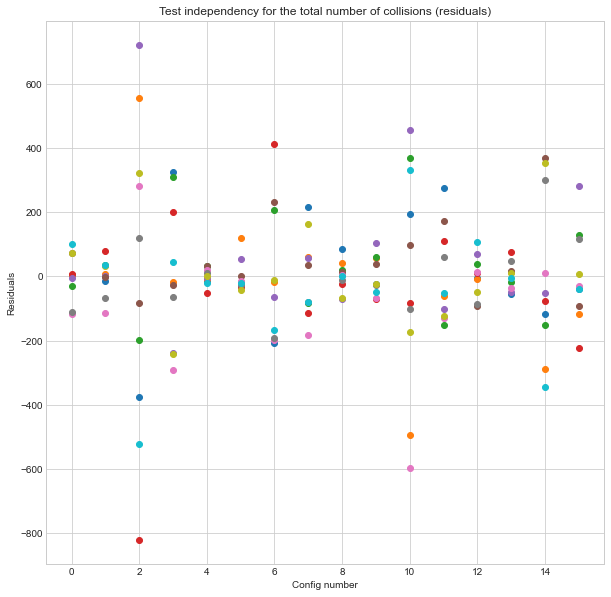

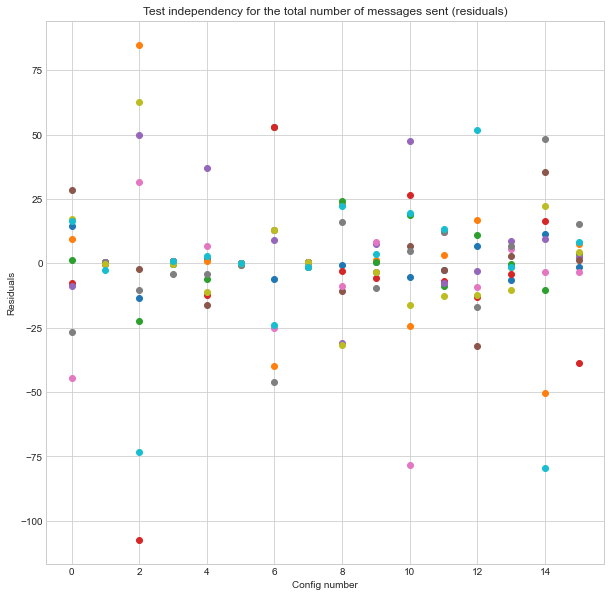

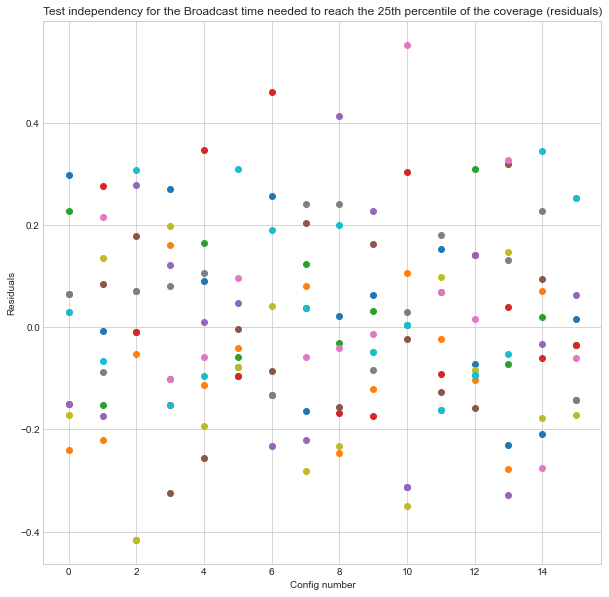

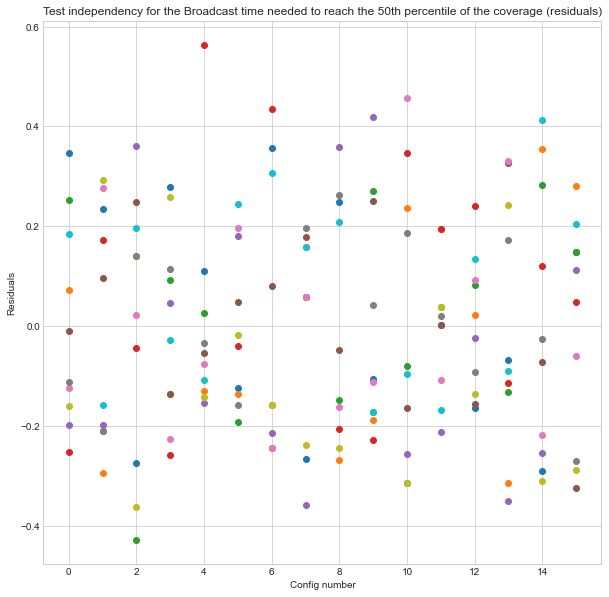

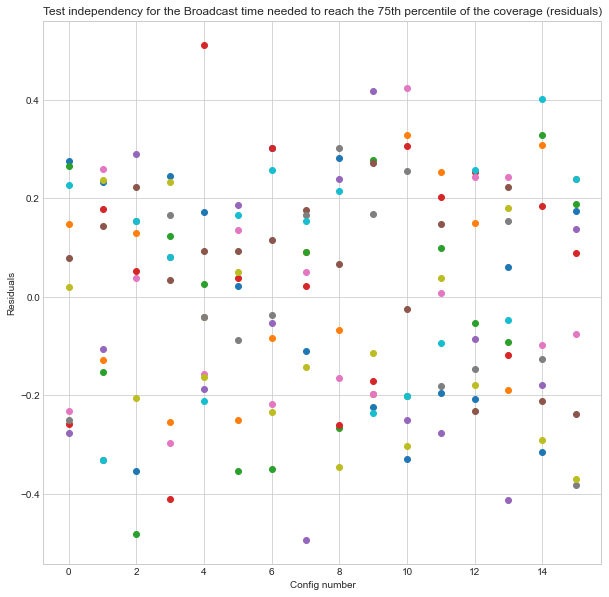

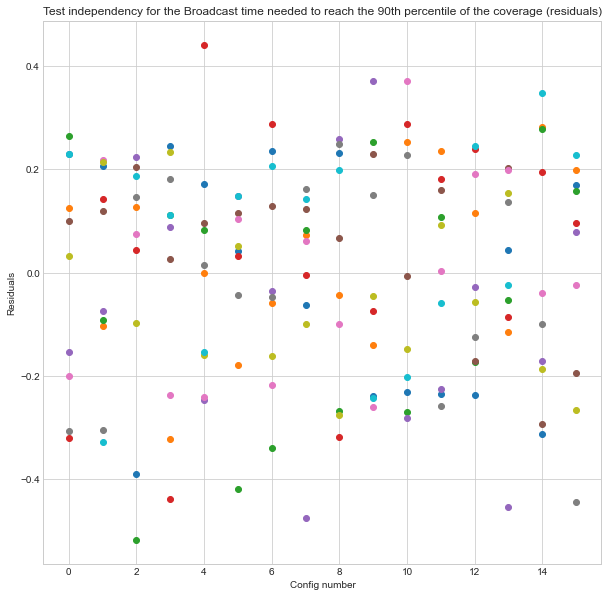

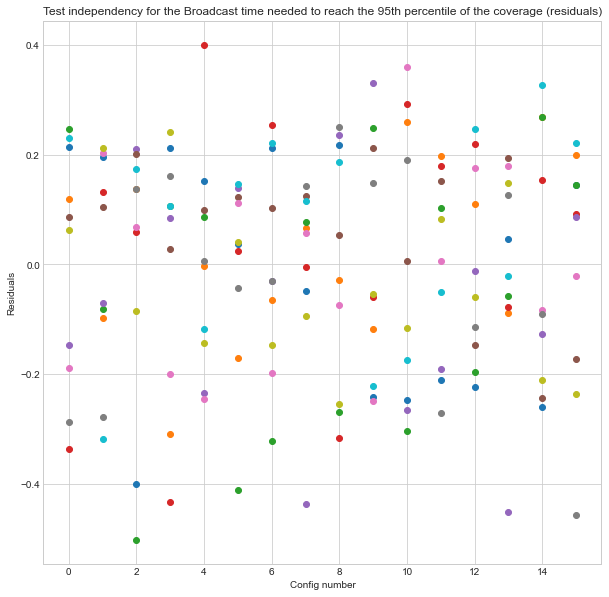

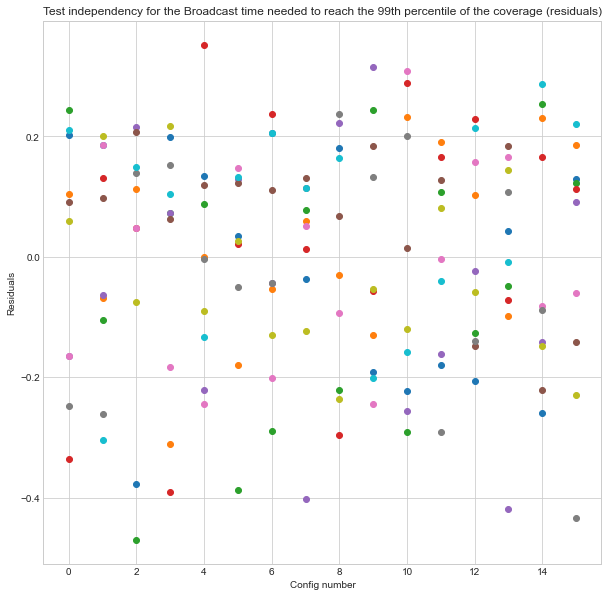

In [13]:
display(scalars_wide.loc[(scalars_wide.repetition == 0) & (scalars_wide.config.isin(configsShown))][['config', *factors]])
for varname, vardesc in residualNames:
    y = []
    x = []
    for config in range(0, configsCount):
        if config not in configsShown:
            continue
        x.append([config] * len(repetitionsShown))
        y.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Residual'].values.tolist())
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.plot(x, y, 'o' + ('-' if scatterShowLines else ''))
    plt.title("Test independency for the " + vardesc)
    plt.xlabel("Config number")
    plt.ylabel("Residuals")
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + get_file_name(varname) + '-independency.png')
    plt.show()

### Notes on indipendency test

No trend is visible. We expected this result as there is no suspect of dependency between experiments by the way we have conducted the experiments.

(percentage of covered users ignored)

## Finite variance test

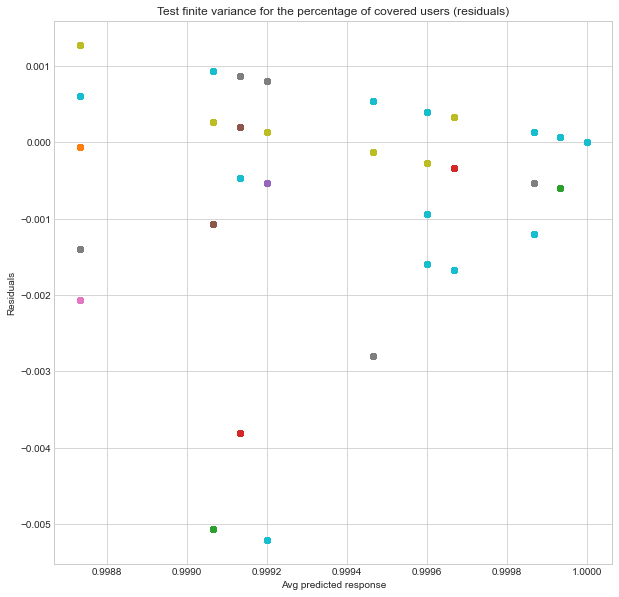

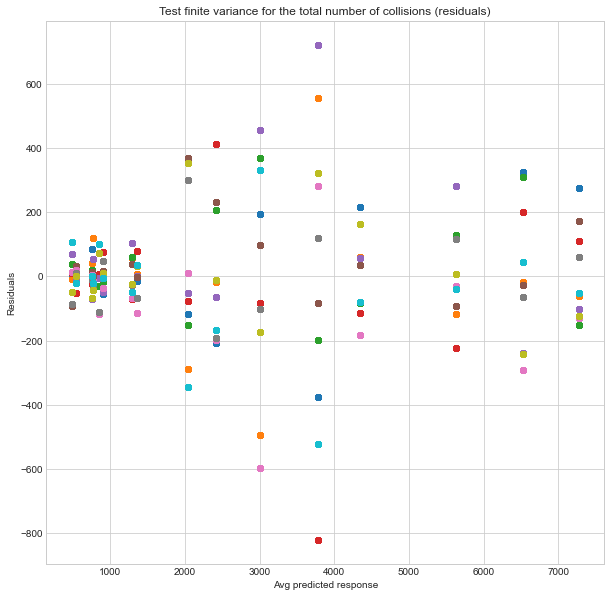

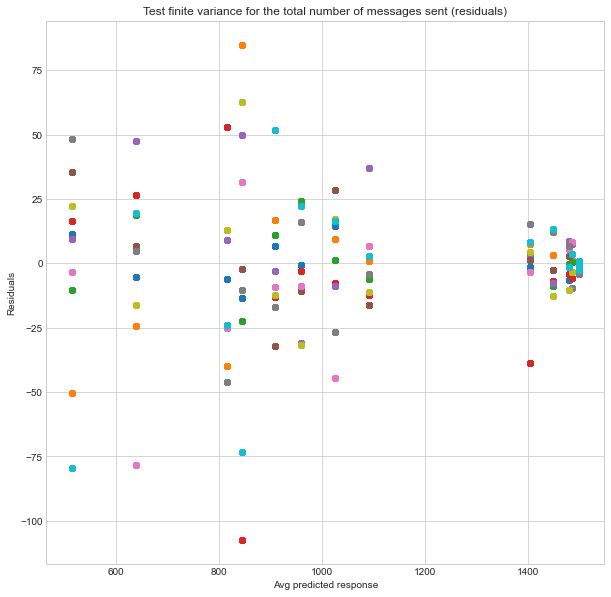

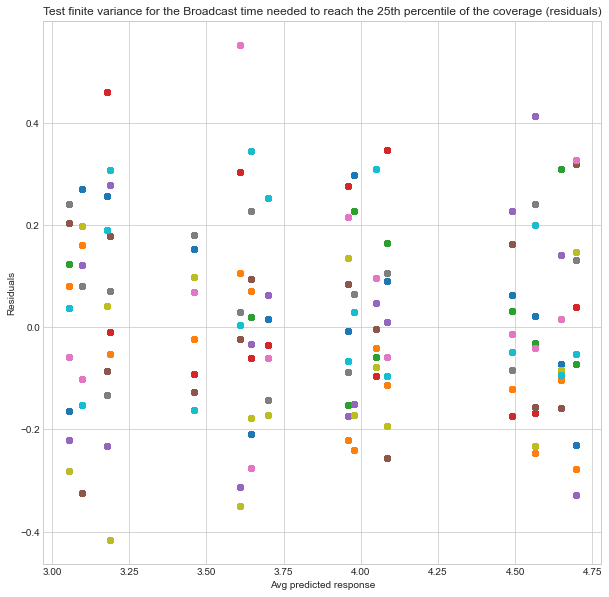

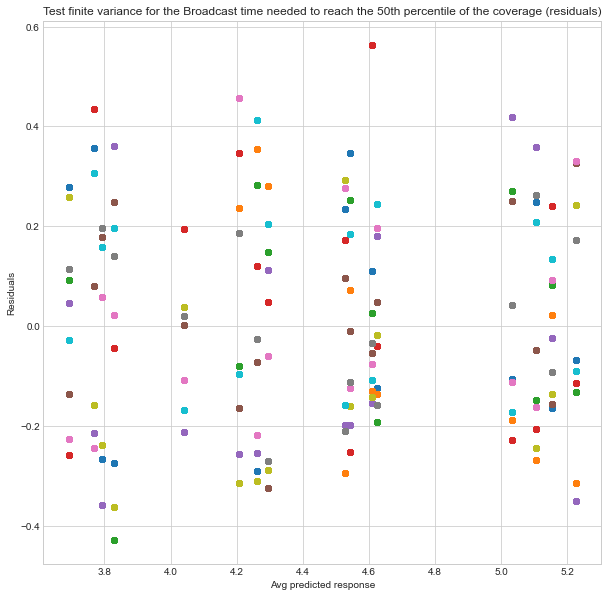

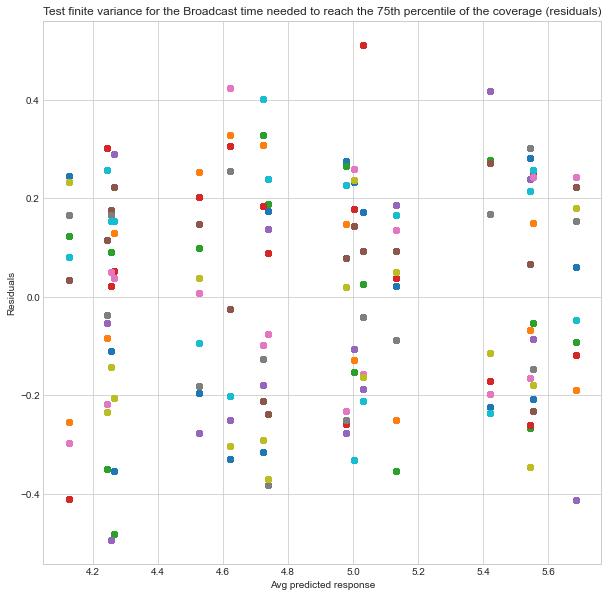

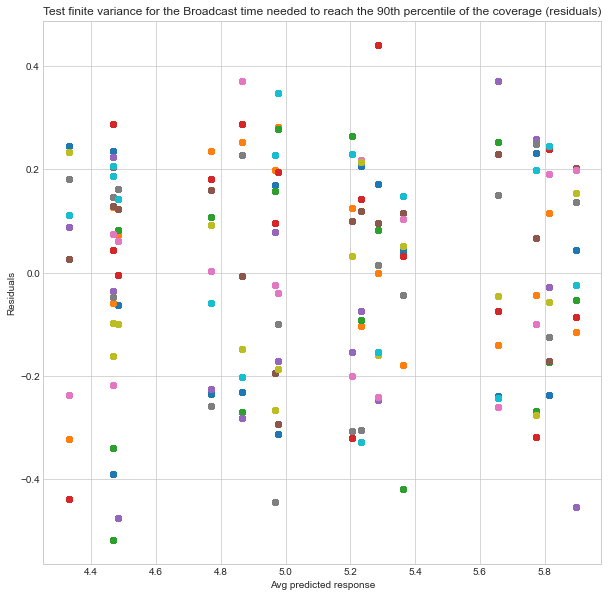

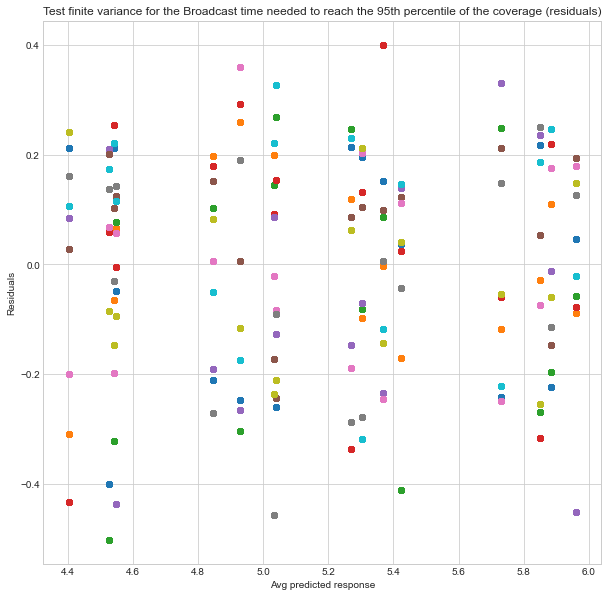

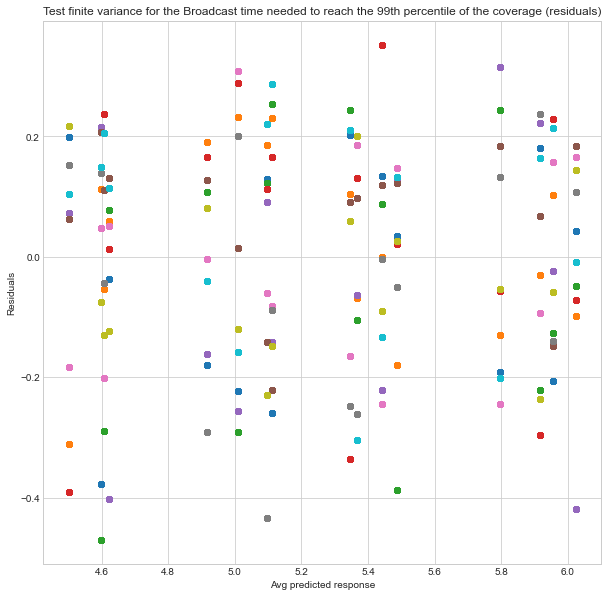

In [14]:
for varname, vardesc in residualNames:
    y = []
    x = []
    scalars_wide.sort_values([varname + 'Mean', 'repetition'], inplace=True)
    for _, row in scalars_wide.iterrows():
        config = row['config']
        if config not in configsShown:
            continue
        x.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Mean'].values.tolist())
        y.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Residual'].values.tolist())
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.plot(x, y, 'o' + ('-' if scatterShowLines else ''))
    plt.title("Test finite variance for the " + vardesc)
    plt.xlabel("Avg predicted response")
    plt.ylabel("Residuals")
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + get_file_name(varname) + '-variance.png')
    plt.show()

### Notes in finite variance test

In both the collision and the messages plots, we have a blockwise behaviour (every block in the scatterplot has similar residuals), but there isn't a trend, because the changes are swinging. So also this assumption is verified (considering also that the residuals are one order of magnitude lower than the predicted variable). 
As in other scenarios, for the broadcast time we applied a logarithmic transformation.

(percentage of covered users ignored)

### Rerun this notebook

To rerun this notebook, you can:
- just rerun the simulations with the corresponding configuration: `./simulate.sh -s Rectangular -c Rectangular2kr` (you will get slighly different results)
- download our datasets from `https://drive.google.com/file/d/1ZFRV2DecoTvax9lngEsuPPw8Cz1DXvLc/view?usp=sharing` (login with UNIPI institutional account)
- use our seed to rerun the simulations. Add `seed-set = ${runnumber}26040` to the configuration